<a href="https://colab.research.google.com/github/Aman-Yadav-PY/Aman-Yadav/blob/master/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import nltk
import re

from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder



2025-08-07 07:36:32.051021: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-07 07:36:32.798000: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754552193.047891      23 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754552193.107066      23 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754552193.525975      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [5]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 128

In [6]:
stemmer= PorterStemmer()
lemmatizer = WordNetLemmatizer()

typeEncoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore',  dtype=np.int32)

In [7]:
train = pd.read_csv("twitter_training.csv", names=['Index', 'Company', 'type', 'sentence'], index_col='Index')
train = train.loc[:, ['type', 'sentence']]
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74682 entries, 2401 to 9200
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   type      74682 non-null  object
 1   sentence  73996 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB


In [8]:
def clean_tweet(txt):
    text = re.sub(r'http\S+', '', txt)
    text = re.sub(r'@\w+', '', txt)
    text = re.sub(r'#\w+', '', txt)
    text = re.sub(r'[^\w\s]', '', txt)
    text = text.lower().strip()
    return text

def preprocessing(txt):
    txt = str(txt)
    txt = clean_tweet(txt)
    txt = [word for word in word_tokenize(txt) if word not in set(stopwords.words('english'))]
    txt = [stemmer.stem(word) for word in txt]
    txt = [lemmatizer.lemmatize(word) for word in txt]
    return txt

def vector(txt):
    sample = []
    for token in txt:
        sample.append(vocab.index(token))

    padded_sample = sample[:MAX_LENGTH] + [0] * (MAX_LENGTH - len(sample))
    return tf.constant(padded_sample, dtype=tf.int32)


def dataset(data, test=False):
    tweets, labels = data.sentence, data.type
    emb = list(tweets.apply(vector))

    if test:
        labels = typeEncoder.transform(labels.values.reshape(-1, 1)), 
    else:
        labels = typeEncoder.fit_transform(labels.values.reshape(-1, 1))

    return tf.data.Dataset.from_tensor_slices((emb, labels))

In [9]:
train.sentence = train.sentence.apply(preprocessing)

In [10]:
MAX_LENGTH = max(len(txt) for txt in train.sentence)
MAX_LENGTH

198

In [11]:
vocab = list(set([word for txt in train['sentence'] for word in txt]))
vocab_dim = len(vocab)
vocab_dim

33549

In [12]:
train, test = train_test_split(train, train_size=0.7)
test, valid = train_test_split(test, train_size=0.5)

len(train), len(test), len(valid)

(52277, 11202, 11203)

In [13]:
train_set = dataset(train)
test_set = dataset(test, test=True)
val_set  = dataset(valid, test=True)

I0000 00:00:1754552414.251444      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3620 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [14]:
train_ds = train_set.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_set.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_set.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [16]:
model = tf.keras.Sequential([
    layers.InputLayer((MAX_LENGTH, )),
    layers.Embedding(vocab_dim + 1, 300),
    layers.Flatten(),
    
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(256, activation='swish'),

    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='swish'),

    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='swish'),
    
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(4, activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tf.metrics.F1Score])

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_loss', patience=5)

history = model.fit(train_ds, validation_data=val_ds,epochs=100, batch_size=BATCH_SIZE, callbacks=[early_stopping])

Epoch 1/100


I0000 00:00:1754553131.622236     120 service.cc:152] XLA service 0x7fe6c8007490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754553131.622790     120 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2025-08-07 07:52:11.918364: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754553133.111877     120 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1754553140.446917     120 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


409/409 ━━━━━━━━━━━━━━━━━━━━ 32s 47ms/step - f1_score: 0.2851 - loss: 1.6259 - val_f1_score: 0.3599 - val_loss: 1.2607
Epoch 2/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - f1_score: 0.5856 - loss: 0.9407 - val_f1_score: 0.6725 - val_loss: 0.8362
Epoch 3/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - f1_score: 0.8273 - loss: 0.4524 - val_f1_score: 0.7884 - val_loss: 0.5451
Epoch 4/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - f1_score: 0.8905 - loss: 0.2960 - val_f1_score: 0.8372 - val_loss: 0.4465
Epoch 5/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - f1_score: 0.9128 - loss: 0.2389 - val_f1_score: 0.8390 - val_loss: 0.4563
Epoch 6/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - f1_score: 0.9236 - loss: 0.2050 - val_f1_score: 0.8313 - val_loss: 0.5033
Epoch 7/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - f1_score: 0.9270 - loss: 0.1970 - val_f1_score: 0.8408 - val_loss: 0.4762
Epoch 8/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - f1_score: 0.9318 - loss: 0.1823 - val_f1_s

<Axes: >

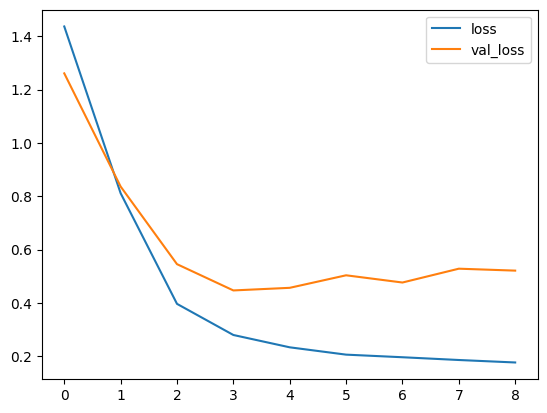

In [18]:
df = pd.DataFrame(history.history)
df[['loss', 'val_loss']].plot()

In [80]:
model.save_weights("model.weights.h5")

In [78]:
model.evaluate(test_ds)

88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - f1_score: 0.8347 - loss: 0.4605  


[0.48452356457710266,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.8078685, 0.862324 , 0.8031989, 0.8343253], dtype=float32)>]

In [63]:
typeEncoder.get_feature_names_out()

array(['x0_Irrelevant', 'x0_Negative', 'x0_Neutral', 'x0_Positive'],
      dtype=object)

In [ ]:
x = val_ds.as_numpy_iterator()
data, label = next(x)

In [ ]:
labels = [l.tolist().index(1) for l in label[0]]
pred = model.predict(data)
y_pred = np.array([y.tolist().index(max(y)) for y in pred])
(y_pred == labels).sum()/BATCH_SIZE